In [2]:
#using this guide: https://towardsdatascience.com/fine-tuning-the-bart-large-model-for-text-summarization-3c69e4c04582

In [3]:
##Import and prepare the data

!pip install ohmeow-blurr -q
!pip install bert-score -q

import pandas as pd
from fastai.text.all import *
from transformers import *
from blurr.data.all import *
from blurr.modeling.all import *

     |████████████████████████████████| 91 kB 4.8 MB/s 
     |████████████████████████████████| 298 kB 15.1 MB/s 
     |████████████████████████████████| 189 kB 55.5 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 3.4 MB 50.7 MB/s 
     |████████████████████████████████| 1.2 MB 46.5 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 
     |████████████████████████████████| 596 kB 43.9 MB/s 
     |████████████████████████████████| 61 kB 481 kB/s 
     |████████████████████████████████| 895 kB 44.6 MB/s 
     |████████████████████████████████| 3.3 MB 39.7 MB/s 
     |████████████████████████████████| 243 kB 52.3 MB/s 
     |████████████████████████████████| 132 kB 64.9 MB/s 
     |████████████████████████████████| 1.1 MB 52.4 MB/s 
     |████████████████████████████████| 192 kB 65.8 MB/s 
     |████████████████████████████████| 160 kB 48.8 MB/s 
     |████████████████████████████████| 271 kB 56.0 MB/s 
     |████████████████

In [4]:
!pip install google.colab
from google.colab import files
uploaded = files.upload()

Saving Datafiniti_Hotel_Reviews.csv to Datafiniti_Hotel_Reviews.csv


In [5]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Datafiniti_Hotel_Reviews.csv']), error_bad_lines=False)
df = df.dropna().reset_index()

#Select part of data we want to keep
df = df[['reviews.title','reviews.text']]

#Clean text
df['reviews.text'] = df['reviews.text'].apply(lambda x: x.replace('\n',''))

#Select only part of it (makes testing faster)
reviews = df.head(150)
reviews.head()

,reviews.title,reviews.text
0,Best romantic vacation ever!!!!,Our experience at Rancho Valencia was absolutely perfect from beginning to end!!!! We felt special and very happy during our stayed. I would come back in a heart beat!!!
1,Sweet sweet serenity,Amazing place. Everyone was extremely warm and welcoming. We've stayed at some top notch places and this is definitely in our top 2. Great for a romantic getaway or take the kids along as we did. Had a couple stuffed animals waiting for our girls upon arrival. Can't wait to go back.
2,Amazing Property and Experience,"We booked a 3 night stay at Rancho Valencia to play some tennis, since it is one of the highest rated tennis resorts in America. This place is really over the top from a luxury standpoint and overall experience. The villas are really perfect, the staff is great, attention to details (includes fresh squeezed orange juice each morning), restaurants, bar and room service amazing, and the tennis program was really impressive as well. We will want to come back here again."
3,"Never again...beware, if you want sleep.",Currently in bed writing this for the past hr 1/2 there have been dogs barking and squealing call the front desk to advise basically to be told there's nothing they can do. 315.00 and I can't sleep.
4,ALWAYS GREAT STAY...,I live in Md and the Aloft is my Home away from home...we stayed 1 night 7-7-16 ...Staff is great ! Especially Olivia who was Extra special because she remembered me by my voice over the phone ...which tells me she is very alert and pays attention to the customer their needs.AND SHE DID ! Thumbs up... More


In [6]:
##Import the model 

In [7]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
                                                                  model_cls=BartForConditionalGeneration)

#Create mini-batch and define parameters
hf_batch_tfm = HF_Seq2SeqBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
    task='summarization',
    text_gen_kwargs=
 {'max_length': 400,'min_length': 2,'do_sample': False, 'early_stopping': True, 'num_beams': 4, 'temperature': 1.0, 
  'top_k': 50, 'top_p': 1.0, 'repetition_penalty': 1.0, 'bad_words_ids': None, 'bos_token_id': 0, 'pad_token_id': 1,
 'eos_token_id': 2, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'encoder_no_repeat_ngram_size': 0,
 'num_return_sequences': 1, 'decoder_start_token_id': 2, 'use_cache': True, 'num_beam_groups': 1,
 'diversity_penalty': 0.0, 'output_attentions': False, 'output_hidden_states': False, 'output_scores': False,
 'return_dict_in_generate': False, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2, 'remove_invalid_values': False})


#Prepare data for training
blocks = (HF_Seq2SeqBlock(before_batch_tfm=hf_batch_tfm), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader('reviews.text'), get_y=ColReader('reviews.title'), splitter=RandomSplitter())
dls = dblock.dataloaders(reviews, batch_size = 5)

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

In [8]:
##Define performance metrics

In [9]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'fr' },
            'returns': ["precision", "recall", "f1"]}}

#Model
model = HF_BaseModelWrapper(hf_model)
learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

#Specify training
learn = Learner(dls, model,
                opt_func=ranger,loss_func=CrossEntropyLossFlat(),
                cbs=learn_cbs,splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

#Create optimizer with default hyper-parameters
learn.create_opt() 
learn.freeze()

#Training
learn.fit_one_cycle(10, lr_max=3e-5, cbs=fit_cbs)

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.93k [00:00<?, ?B/s]

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time
0,7.853690,7.256357,0.116096,0.060446,0.114540,0.618940,0.683633,0.649040,00:42
1,7.202875,5.780510,0.150580,0.089260,0.142753,0.629726,0.675398,0.650967,00:10
2,6.254847,4.365908,0.128818,0.080952,0.126869,0.654552,0.670347,0.661252,00:09
3,4.915466,2.694332,0.090370,0.066667,0.087500,0.667267,0.669640,0.667837,00:08
4,3.733169,2.393442,0.072222,0.055556,0.069064,0.688100,0.685524,0.686008,00:08
5,2.914433,2.401837,0.070000,0.055556,0.067037,0.687590,0.683262,0.684730,00:08
6,2.339251,2.386777,0.066667,0.055556,0.063509,0.687912,0.683248,0.684941,00:08
7,1.952106,2.374422,0.066667,0.055556,0.060000,0.679012,0.678798,0.678446,00:08
8,1.694629,2.395993,0.066667,0.055556,0.060000,0.685136,0.684686,0.684343,00:08
9,1.525492,2.401037,0.066667,0.055556,0.061709,0.683210,0.684719,0.683342,00:09


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

In [10]:
df['reviews.text'][0]

'Our experience at Rancho Valencia was absolutely perfect from beginning to end!!!! We felt special and very happy during our stayed. I would come back in a heart beat!!!'

In [11]:
outputs = learn.blurr_generate(df['reviews.text'][0], early_stopping=False, num_return_sequences=1)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
 Best Hotel in the World!!!! Rancho Valencia was absolutely perfect from beginning to end!!!! We felt special and very happy during our stayed. I would come back in a heart beat!!! Back to Mail Online home. Back to the page you came from. Click here for more information.



In [12]:
b = dls.one_batch()
preds = learn.model(b[0])
len(preds),preds[0], preds[1].shape

(4,
 tensor(1.3270, device='cuda:0', grad_fn=<NllLossBackward0>),
 torch.Size([5, 23, 50264]))

In [13]:
learn.show_results(learner=learn, max_n=10)


,text,target,prediction
0,"Bad: We had booked 2 rooms for our 3 night Boston trip - King Room for us and a Double Double (ie with 2 double beds) for our teenagers. I booked this in December for our July visit. I emailed twice before arrival to request that the rooms were close by (on the same floor) and both times got no reply - and that should have alerted me and to be honest sums up 'Boxer Customer Service'. On arrival we were told that there were no rooms available with 2 beds, the guy on reception seemed clueless how to help us. Our teenagers were supposedly 'upgraded' to a suite where my son had to sleep on a sofa / pull out bed (or share a King size bed with his sister). Totally unacceptable - I booked these rooms 6 months in advance. All in all we had interactions with 4 different staff members (including someone from Accounts who had to process a compensation refund) and at no time did either my wife nor I feel like the Customer.... you know the kind The PAYING Customer! So in terms of Comfort score - low because my son was on a sofa bed for 3 nights. In terms of Value for Money - low 1800 and my 16 year old son gets a sofa bed In terms of Staff score - low because they are in serious need of some Customer Service training. Good: The Boxer in Boston SHOULD be a fantastic hotel - it's a great building, location is excellent (we were able to explore everything that Boston has to offer from there), rooms are a good size but overall our stay was not as good as it should have been. Came away from our 3 night stay (planned and booked 6 months earlier) just feeling like we had been let down....",The Boxer Boston a let down and should have been better!,Great location but not great customer service.
1,"Loved this place! If you are looking for a chain hotel, THIS IS NOT for you. If you are looking for different, unique, friendly, fun...then this is it. We chose the little room with Queen bed, no windows..and it was GREAT. Best bed I've slept in while traveling in a long long time. Although there are internal hotel noises every once and a while..it was by no means disturbing or loud. Location was awesome! We mainly hung out on Decatour street/Jackson square/French market..but even bourbon street was a short walk. Hotel staff is very knowledgeable about places to eat and things to do. We didn't drive here so no idea about parking or valet. Staff was extremely friendly. It's just a super little gem in a crazy town.",Hotel with Personality!,Best bed I've slept in while traveling in a long long time. Location was awesome!
2,"Brand new hotel in brand new retail area on the water. Easy to access off the beltway. Friendly staff, clean rooms, comfortable beds. Only complaint is that the full offering of the Hampton Inn breakfast was not available at the two times we came down (at 7am and 9am on a Saturday). The food at 9am had been in the bin too long. Still more choices than the continental breakfast at other places, including make-you-own waffles and yummy egg burritos. The fee for parking in the community garage was free with room key and even included a convenient room key drop upon final exit. Pool but no hot tub.","beautiful, convenient location","Friendly staff, clean rooms, comfortable beds."
3,"Bad: A little sticker shock with 65/night valet parking, but I hadn't done my research for cheaper options, so not a big deal. Good: Super hip and definitely a young techy vibe, but everyone was friendly and helpful. Room was as described and very spacious for the location and price. Even though it is right at the corner of the L Tracks, sound wasn't a problem. Exactly what was needed!","Fun, Funky Energy to a Shiny New Hotel","Great location, great staff, great price!"
4,"The staff is very friendly and helpful. The rooms are large and nicely furnished. Feels new, as if we were the first to stay there. Actually it is more opulent than I require. The free breakfast was good with sufficient choices including fresh fruit salad, eggs, bacon, 

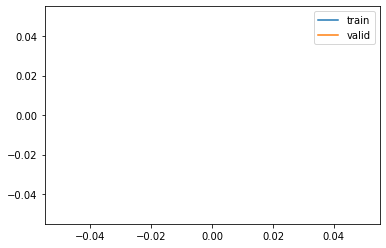

In [14]:
learn.recorder.plot_loss()